In [1]:
train_gan = True #@param {type:"boolean"}
download_state = True #@param {type:"boolean"}
load_state = "False"  #@param ["False", "From URL", "Upload"]
load_state_url = 'https://github.com/toonnyy8/toy/raw/main/dl/gan/gan.pt' #@param {type:"string"}

if load_state == "From URL":
    !wget {load_state_url}
    
elif load_state == "Upload":
    from google.colab import files

    uploaded = files.upload()

In [2]:
!nvidia-smi

Sun Aug  1 07:31:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install einops

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim

from einops import rearrange, repeat
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, k_size=3):
        super().__init__()
        self.shortcut = nn.Identity() if in_dim == out_dim else nn.Conv2d(in_dim, out_dim, 1)

        self.net = nn.Sequential(
                nn.GroupNorm(1, in_dim),
                nn.GELU(),
                nn.Conv2d(in_dim, max(in_dim, out_dim)*2, k_size, padding=k_size//2),
                nn.GroupNorm(1, max(in_dim, out_dim)*2),
                nn.GELU(),
                nn.Conv2d(max(in_dim, out_dim)*2, out_dim, k_size, padding=k_size//2),
        )
  
    def forward(self, x):
        return self.shortcut(x) + self.net(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, cond_num, latent_dim, pos_dim, dims, out_dim, scale):
        super().__init__()
        self.B = nn.Parameter(torch.randn(2, pos_dim, device=device)*scale, requires_grad=False)
        self.cond_vecs = nn.Parameter(torch.randn(cond_num, 2, pos_dim, device=device)*scale, requires_grad=False)# torch.eye(cond_num, device=device)

        self.net = nn.Sequential(
            nn.Conv2d(pos_dim*4+latent_dim, dims[0], 1),
            *[ResBlock(dims[i], dim, 1) for i, dim in enumerate(dims[1:])],
            nn.GroupNorm(1, dims[-1]),
            nn.GELU(),
            nn.Conv2d(dims[-1], out_dim, 1),
            nn.Sigmoid(),
        )
  
    def forward(self, conds, latent_vecs, H, W):
        coords_x = np.linspace(0, 1, W,)
        coords_y = np.linspace(0, 1, H,)
        coords = np.stack(np.meshgrid(coords_x, coords_y), 0) # (C, H, W)
        coords = torch.tensor(coords, dtype=torch.float32, device=device)

        pos_emb = repeat(torch.einsum('chw,cd->dhw', coords, self.B), 'd h w -> b d h w', b=len(conds))
        cond_pos_emb = torch.einsum('chw,bcd->bdhw', coords, self.cond_vecs[conds])
        u = 2*math.pi*torch.cat([pos_emb, cond_pos_emb], 1)

        v = repeat(latent_vecs, 'b d -> b d h w', h=H, w=W)
        z = torch.cat([torch.cos(u), torch.sin(u), v], 1)

        out = self.net(z)
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self, class_num, latent_dim, dims,):
        super().__init__()
        self.class_num = class_num
        self.latent_dim = latent_dim

        creat_nn = lambda in_dim, dim: nn.Sequential(
                ResBlock(in_dim, dim, 3),
                nn.AvgPool2d(2,2),
            )

        self.net = nn.Sequential(
            *[creat_nn(dims[i], dim) for i, dim in enumerate(dims[1:])],
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dims[-1], dims[-1]*2, 1,),
            nn.ReLU(),
            nn.Conv2d(dims[-1]*2, class_num+latent_dim, 1,),
            nn.Flatten(),
        )
  
    def forward(self, x):
        out = self.net(x)
        return out[:,:self.class_num], out[:,self.class_num:]

In [10]:
ce_fn = nn.CrossEntropyLoss()
similarity_fn = nn.CosineSimilarity()
mse_fn = nn.MSELoss()

epochs = 30
batch_size = 128
latent_dim = 8
cond_num = 10

In [11]:
g_net = Generator(cond_num, latent_dim, 128, [64, 64, 64], 1, 1).to(device)
g_opt = optim.Adamax(params=g_net.parameters())

In [12]:
d_net = Discriminator(cond_num+1, latent_dim, [1, 32, 64, 128],).to(device)
d_opt = optim.Adamax(params=d_net.parameters())

In [13]:
if not (load_state == 'False'):
    checkpoint = torch.load("./gan.pt", map_location=device)

    g_net.load_state_dict(checkpoint['g_net'])
    g_opt.load_state_dict(checkpoint['g_opt'])

    d_net.load_state_dict(checkpoint['d_net'])
    d_opt.load_state_dict(checkpoint['d_opt'])

In [14]:
if train_gan:
    transform = transforms.Compose([
    transforms.ToTensor(),            
    ])
    trainSet = MNIST(root='MNIST', download=True, train=True, transform=transform)
    trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


100%|██████████| 469/469 [01:02<00:00,  7.55it/s]


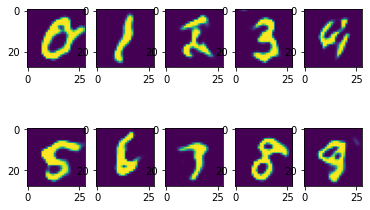

100%|██████████| 469/469 [01:05<00:00,  7.21it/s]


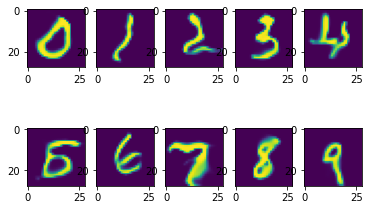

100%|██████████| 469/469 [01:05<00:00,  7.19it/s]


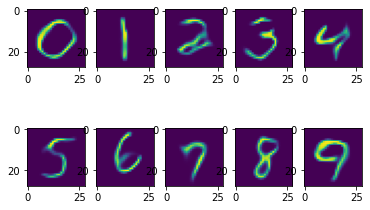

100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


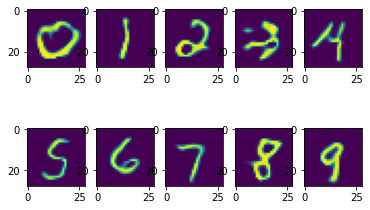

100%|██████████| 469/469 [01:06<00:00,  7.06it/s]


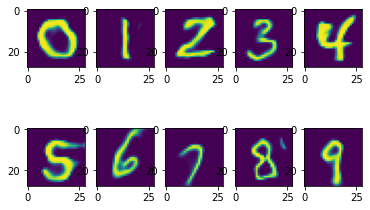

100%|██████████| 469/469 [01:05<00:00,  7.11it/s]


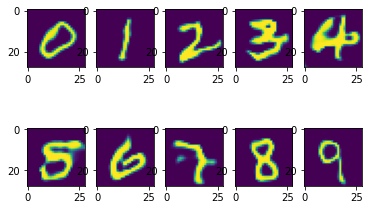

100%|██████████| 469/469 [01:05<00:00,  7.11it/s]


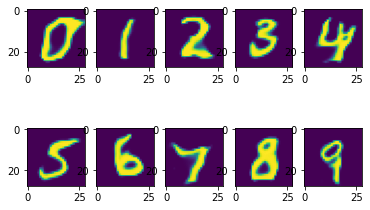

100%|██████████| 469/469 [01:06<00:00,  7.08it/s]


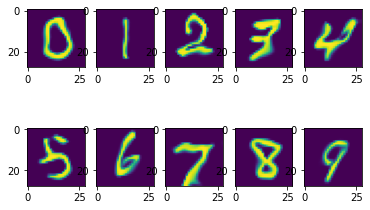

100%|██████████| 469/469 [01:06<00:00,  7.08it/s]


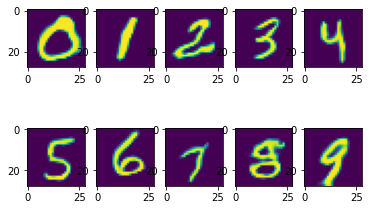

100%|██████████| 469/469 [01:06<00:00,  7.06it/s]


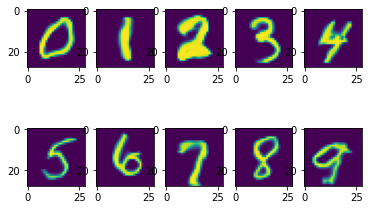

100%|██████████| 469/469 [01:06<00:00,  7.03it/s]


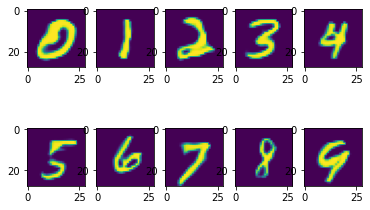

100%|██████████| 469/469 [01:06<00:00,  7.04it/s]


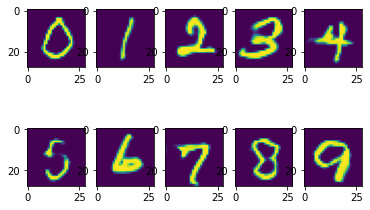

100%|██████████| 469/469 [01:06<00:00,  7.04it/s]


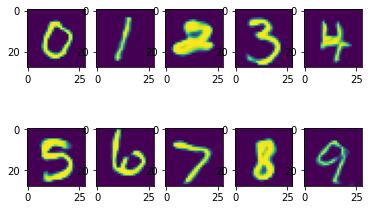

100%|██████████| 469/469 [01:06<00:00,  7.03it/s]


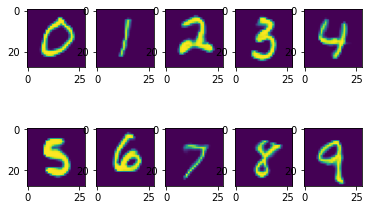

100%|██████████| 469/469 [01:07<00:00,  6.97it/s]


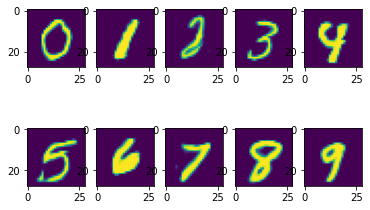

100%|██████████| 469/469 [01:06<00:00,  7.02it/s]


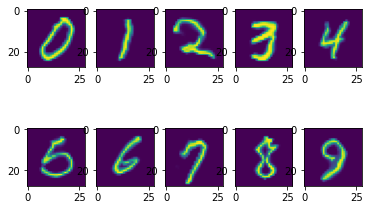

100%|██████████| 469/469 [01:06<00:00,  7.03it/s]


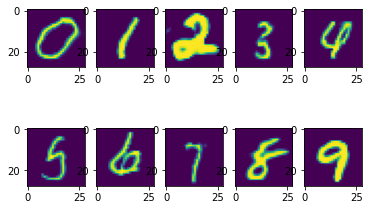

100%|██████████| 469/469 [01:06<00:00,  7.03it/s]


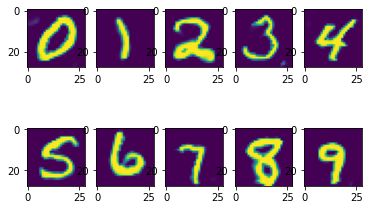

100%|██████████| 469/469 [01:06<00:00,  7.01it/s]


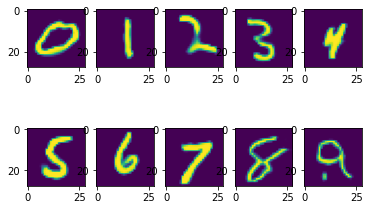

100%|██████████| 469/469 [01:06<00:00,  7.00it/s]


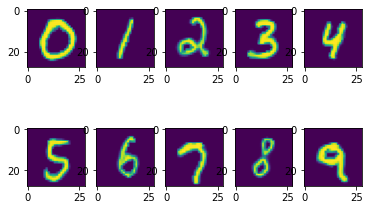

100%|██████████| 469/469 [01:06<00:00,  7.00it/s]


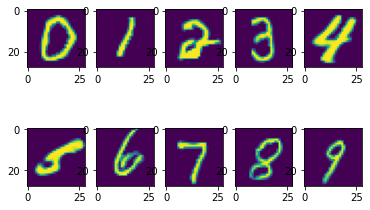

100%|██████████| 469/469 [01:06<00:00,  7.01it/s]


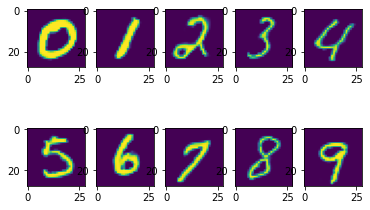

100%|██████████| 469/469 [01:06<00:00,  7.01it/s]


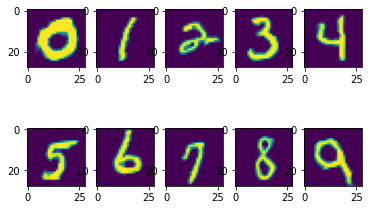

100%|██████████| 469/469 [01:07<00:00,  6.98it/s]


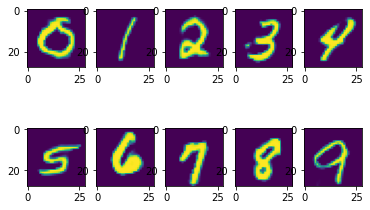

100%|██████████| 469/469 [01:07<00:00,  6.97it/s]


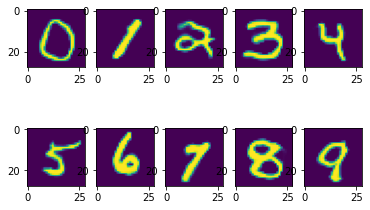

100%|██████████| 469/469 [01:07<00:00,  6.99it/s]


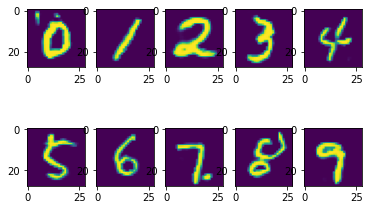

100%|██████████| 469/469 [01:07<00:00,  6.98it/s]


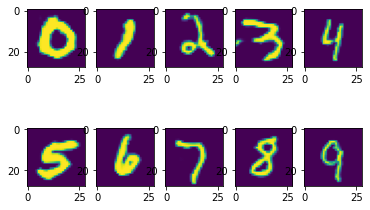

100%|██████████| 469/469 [01:07<00:00,  6.97it/s]


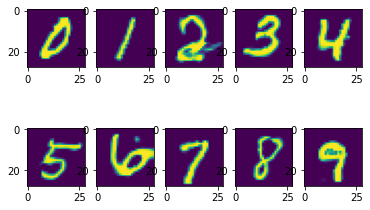

100%|██████████| 469/469 [01:07<00:00,  6.91it/s]


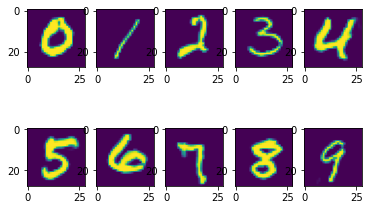

100%|██████████| 469/469 [01:07<00:00,  7.00it/s]


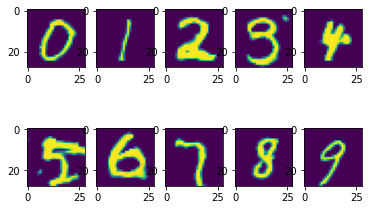

In [15]:
if train_gan:
    for epoch in range(epochs):
        for (imgs,labels) in tqdm(trainLoader):
            gc.collect()
            torch.cuda.empty_cache()

            _bz = labels.shape[0]
            imgs = imgs.to(device)
            labels = labels.to(device)

            # gen fake
            fake_labels = torch.ones(_bz, dtype=torch.int64, device=device)*10
            latent_vecs = torch.randn(_bz, latent_dim, device=device)
            g_out = g_net(labels, latent_vecs, H=28, W=28)

            # train D
            d_real_out = d_net(imgs)
            d_real_loss = ce_fn(d_real_out[0], labels)

            d_fake_out = d_net(g_out.detach())
            d_fake_loss = ce_fn(d_fake_out[0], fake_labels)-similarity_fn(latent_vecs, d_fake_out[1]).mean()
            
            d_loss = d_real_loss+d_fake_loss
            d_loss.backward()
            d_opt.step()
            d_opt.zero_grad()
            
            # train G
            d_out = d_net(g_out)
            g_loss = ce_fn(d_out[0], labels)-similarity_fn(latent_vecs, d_out[1]).mean()
            g_loss.backward()
            g_opt.step()
            g_opt.zero_grad()
            
        with torch.no_grad():
            labels = torch.arange(0, 10, device=device)
            latent_vecs = torch.randn(10, latent_dim, device=device)

            g_out = g_net(labels, latent_vecs, H=28, W=28)

            fig , ax = plt.subplots()
            for i in range(1, 11):
                plt.subplot(2, 5, i)
                plt.imshow(g_out[i-1,0].cpu().data)
            plt.show()


In [16]:
if download_state:
    torch.save({
        "g_net":g_net.state_dict(),
        "g_opt":g_opt.state_dict(),
        "d_net":d_net.state_dict(),
        "d_opt":d_opt.state_dict(),
    }, './gan.pt')

    from google.colab import files

    files.download('./gan.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#@title 生成數字
%matplotlib inline
from ipywidgets import interactive, widgets

gen_number = 0  #@param {type:"slider", min:0, max:9, step:1}
gen_size = 28  #@param {type:"slider", min:16, max:128, step:1}

g_net.eval()

def f(**kwargs):
    latent_vec = torch.tensor([[kwargs['dim {}'.format(i)] for i in range(latent_dim)]], device=device)
    with torch.no_grad():
        g_out = g_net(torch.tensor([int(gen_number)], device=device), latent_vec, H=int(gen_size), W=int(gen_size))
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(g_out[0,0].cpu().data)
    plt.show()

    return
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)
names = [['dim {}'.format(i), [0., -5., 5]] for i in range(latent_dim)]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='dim 0', max=5.0, min=-5.0, step=0.01), FloatSlider(v…